In [1]:
# Import Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from sqlalchemy import create_engine
from sqlalchemy import Column, Integer, String, Float
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Float
import sqlite3
import pandas as pd
import datetime as dt
import numpy as np
import pandas as pd
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM

In [2]:
#create engine by connecting to sqlite database
engine = create_engine(f'sqlite:///hawaii.sqlite')
Base = automap_base()
Base.prepare(engine, reflect=True)

In [3]:
Base.classes.keys()

['measurement', 'station']

In [4]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
#Query recorrd
station_data = engine.execute('select * from station')

# #iterate over data
# for each in data:
    
#     print(each)

In [7]:
# Get the column names
columns = station_data.keys()

# Print the column names
print(columns)

RMKeyView(['id', 'station', 'name', 'latitude', 'longitude', 'elevation'])


In [8]:
#Query recorrd
measurement_data = engine.execute('select * from measurement')

# #iterate over data
# for each in data:
    
#     print(each)

In [9]:
# Get the column names
columns = measurement_data.keys()

# Print the column names
print(columns)

RMKeyView(['id', 'station', 'date', 'prcp', 'tobs'])


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)
session

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
recent_date

'2017-08-23'

In [12]:
# Calculate the date one year from the last date in data set.
one_year_ago =  pd.to_datetime(recent_date) - pd.DateOffset(years=1)
one_year_ago = one_year_ago.strftime('%Y-%m-%d')
one_year_ago

'2016-08-23'

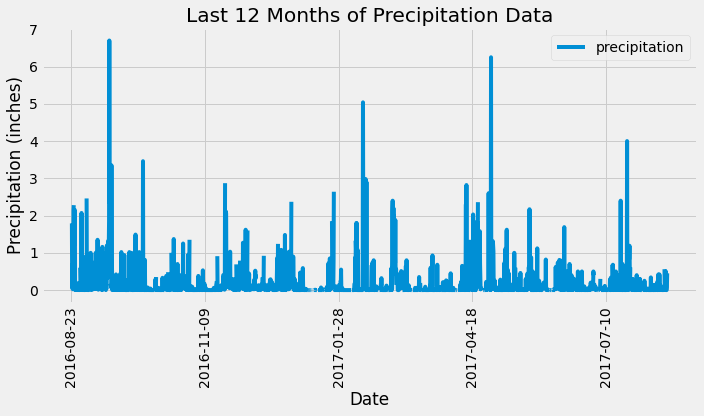

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
prcp_results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago)


# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_results, columns=['date', 'precipitation'])
prcp_df.set_index('date', inplace=True)

# Sort the dataframe by date
prcp_df.sort_values('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot(figsize=(10, 6), rot=90)
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation (inches)")
ax.set_title("Last 12 Months of Precipitation Data")
plt.tight_layout()
plt.show()



In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
import pandas as pd

# Read in the precipitation data
precip_data = prcp_df

# Calculate summary statistics for precipitation data
precip_summary = precip_data["precipitation"].describe()

# Print the summary statistics
print(precip_summary)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
# query total number of stations
total_stations = session.query(Station.station).count()

print(f'Total number of stations: {total_stations}')

Total number of stations: 9


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
from sqlalchemy import func

session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Query most active station
most_active_station = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]

# Query  lowest, highest, and average temperature for most active station
temp_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()

# Print the results
print(f"Temperature Stats for the most active station: {most_active_station}:")
print(f"Lowest Temperature: {temp_stats[0][0]} degrees F")
print(f"Highest Temperature: {temp_stats[0][1]} degrees F")
print(f"Average Temperature: {temp_stats[0][2]} degrees F")


Temperature Stats for the most active station: USC00519281:
Lowest Temperature: 54.0 degrees F
Highest Temperature: 85.0 degrees F
Average Temperature: 71.66378066378067 degrees F


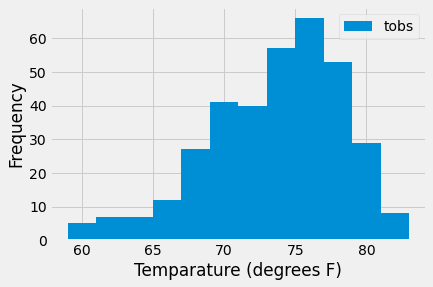

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).filter(Measurement.date >= one_year_ago).all()

# Convert the query results to a DataFrame
temps_df = pd.DataFrame(temps, columns=['date', 'tobs'])

# Plot the results as a histogram
plt.hist(temps_df['tobs'], bins=12, label='tobs')
plt.ylabel('Frequency')
plt.xlabel('Temparature (degrees F)')
plt.legend()
plt.show()


# Close session

In [19]:
# Close Session
session.close()

# Create app.py logic

In [20]:
# create engine and reflect the database
engine = create_engine("sqlite:///hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)

# save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# create session
session = Session(engine)

# create Flask app
app = Flask(__name__)

# define home page and available routes
@app.route("/")
def home():
    return (
        f"Welcome to the Climate Home Page<br/>"
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/&lt;start&gt;<br/>"
        f"/api/v1.0/&lt;start&gt;/&lt;end&gt;<br/>"
    )

# define precipitation route
@app.route("/api/v1.0/precipitation")
def precipitation():
    # calculate the date one year from the last date in data set.
    recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
    one_year_ago = dt.datetime.strptime(recent_date, "%Y-%m-%d") - dt.timedelta(days=365)
    
    # query for precipitation data for the last year and convert to a dictionary
    prcp_results = session.query(Measurement.date, Measurement.prcp).\
                   filter(Measurement.date >= one_year_ago).all()
    prcp_dict = dict(prcp_results)
    
    return jsonify(prcp_dict)

# define stations route
@app.route("/api/v1.0/stations")
def stations():
    # query for list of stations and convert to a list
    station_results = session.query(Station.station).all()
    stations_list = list(np.ravel(station_results))
    
    return jsonify(stations_list)

# define tobs route
@app.route("/api/v1.0/tobs")
def tobs():
    # calculate the date one year from the last date in data set.
    recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
    one_year_ago = dt.datetime.strptime(recent_date, "%Y-%m-%d") - dt.timedelta(days=365)
    
    # query for temperature observations for the last year for the most active station and convert to a list
    active_station = session.query(Measurement.station).\
                     group_by(Measurement.station).\
                     order_by(func.count().desc()).\
                     first()[0]
    
    tobs_results = session.query(Measurement.date, Measurement.tobs).\
                   filter(Measurement.station == active_station).\
                   filter(Measurement.date >= one_year_ago).all()
    tobs_list = list(np.ravel(tobs_results))
    
    return jsonify(tobs_list)

# define start date route
@app.route("/api/v1.0/<start>")
def start_date(start):
    # query for TMIN, TAVG, and TMAX for all dates greater than or equal to the start date
    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
              filter(Measurement.date >= start).all()
    
